In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [2]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 500 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 1 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

import os

In [5]:
lukup = {'defaultCredit':'default.payment.next.month', 'bank':'y'}
name = 'bank'
label = lukup[name]
fold = 1
train_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/train/data.csv'.format(name, fold))
valid_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/valid/data.csv'.format(name, fold))
test_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/test/data.csv'.format(name, fold))
train_label, valid_label, test_label = train_df[label], valid_df[label], test_df[label]
train_df, valid_df, test_df = train_df.drop(label, axis=1), valid_df.drop(label, axis=1), test_df.drop(label, axis=1)
# numerical_feat = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/numerical_clms.csv'.format(name)).columns
# train_df = train_df[numerical_feat]
# valid_df = valid_df[numerical_feat]
# test_df = test_df[numerical_feat]
predictors = train_df.columns
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-1.825529,11,1,1,0,0,0,1,8,0,-0.001099,0.517118,0.195414,1.671136,1,-1.197935,-0.864955,-1.425496,-1.277824,-0.940281
1,1.724952,7,2,1,0,0,0,1,2,0,0.457871,0.517118,0.195414,-0.349494,0,0.839061,0.591424,-0.474791,0.772999,0.845170
2,1.820911,5,2,0,0,1,0,0,0,4,-0.541064,-0.204909,0.195414,-0.349494,0,0.648092,0.722722,0.886447,0.713613,0.331680
3,-0.290186,4,0,4,0,1,0,1,3,4,-0.209371,-0.565922,0.195414,-0.349494,0,0.839061,-0.227465,0.951267,0.773575,0.845170
4,-0.769980,1,1,1,0,0,0,1,0,0,-0.240227,-0.565922,0.195414,-0.349494,0,-1.197935,-1.179380,-1.231034,-1.307228,-0.940281


In [7]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df.values, train_label.values.flatten(), feature_names=predictors)
dvalid = xgb.DMatrix(valid_df.values, valid_label.values.flatten(), feature_names=predictors)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = ['auc','aucpr']
params['random_state'] = RANDOM_STATE

In [8]:

model = xgb.train(params, 
                dtrain, 
                
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[18:10:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.86539	train-aucpr:0.50812	valid-auc:0.84489	valid-aucpr:0.47963


/home/vineeth/anaconda3/envs/pytorch_07_2023/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-auc:0.93050	train-aucpr:0.62276	valid-auc:0.92462	valid-aucpr:0.57551
[100]	train-auc:0.93781	train-aucpr:0.63752	valid-auc:0.93268	valid-aucpr:0.58962
[150]	train-auc:0.94125	train-aucpr:0.64464	valid-auc:0.93590	valid-aucpr:0.59332
[200]	train-auc:0.94334	train-aucpr:0.65235	valid-auc:0.93695	valid-aucpr:0.59773
[250]	train-auc:0.94465	train-aucpr:0.65650	valid-auc:0.93821	valid-aucpr:0.60242
[300]	train-auc:0.94588	train-aucpr:0.66205	valid-auc:0.93931	valid-aucpr:0.60888
[350]	train-auc:0.94697	train-aucpr:0.66670	valid-auc:0.94015	valid-aucpr:0.61321
[400]	train-auc:0.94779	train-aucpr:0.67094	valid-auc:0.94086	valid-aucpr:0.61730
[450]	train-auc:0.94832	train-aucpr:0.67461	valid-auc:0.94136	valid-aucpr:0.61898
[500]	train-auc:0.94912	train-aucpr:0.67837	valid-auc:0.94213	valid-aucpr:0.62407
[550]	train-auc:0.95030	train-aucpr:0.68217	valid-auc:0.94325	valid-aucpr:0.62971
[600]	train-auc:0.95097	train-aucpr:0.68561	valid-auc:0.94359	valid-aucpr:0.63192
[650]	train-auc:0

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
dtest = xgb.DMatrix(test_df.values, feature_names=predictors)
y_pred = model.predict(dtest)
print(classification_report(test_label.values.flatten(), np.rint(y_pred)))

print("ROC-AUC:{}".format(roc_auc_score(test_label.values.flatten(), y_pred)))
print("PrecisionRecall-AUC:{}".format(average_precision_score(test_label.values.flatten(), y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7294
           1       0.67      0.52      0.59       944

    accuracy                           0.92      8238
   macro avg       0.81      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238

ROC-AUC:0.9472500034855674
PrecisionRecall-AUC:0.6686406554107148


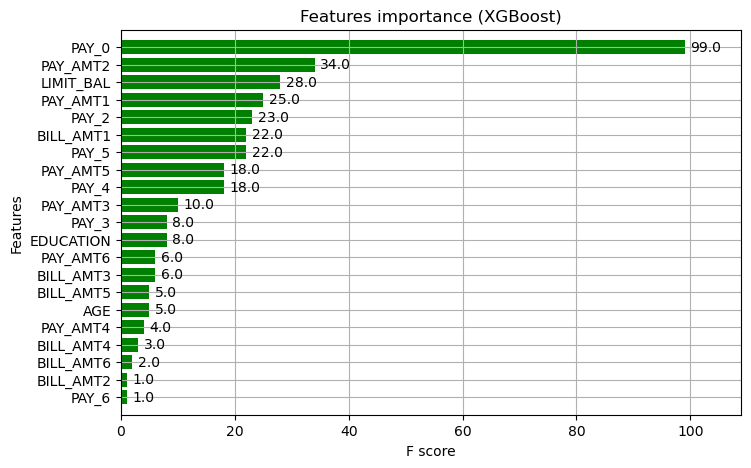

In [31]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()